In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np; np.set_printoptions(precision=4); np.random.seed(0)
import torch; torch.set_printoptions(precision=4)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt; plt.rc('font', size=12); 
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import scipy
import os
import warnings

from textwrap import wrap
from scipy.stats import wilcoxon
from sklearn.metrics.pairwise import cosine_similarity

sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from model_working import *
from functions import *
os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True    

1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Generate data for dendritic branch coding

In [ ]:
start = time.time()

all_data_branch_coding = []

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-01' in model_name or '2023-05-10' in model_name) and 'success' in model_name:
        print(model_name)
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
                
        
        # load test data
        if '{}_testdata_noiseless_no_current_matrix'.format(model_name) not in os.listdir('/scratch/yl4317/two_module_rnn/saved_testdata/'):
            print('did not find testing data, pass\n')
            continue
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}_testdata_noiseless_no_current_matrix'.format(model_name), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
        if np.isnan(rnn_activity).any():
            print('NaN in rnn_activity, pass\n')
            continue
#         current_matrix = neural_data['current_matrix']
        
        mean_perf = np.mean(np.array(test_data['perfs']))
        mean_perf_rule = np.mean(np.array(test_data['perf_rules']))
        if mean_perf<=0.8 or mean_perf_rule<=0.8:
            print('This model performance is low!! {}/{}\n'.format(mean_perf, mean_perf_rule))
            continue
            
        # generate trial labels
        trial_labels = label_trials_wcst(test_data=test_data)
        if len(trial_labels['rule1_trs_stable'])==0 or len(trial_labels['rule2_trs_stable'])==0:
            print('no rule 1 or 2 trials, pass\n')
            continue
        resp_trs_stable = {'c1': trial_labels['c1_trs_stable'], 'c2': trial_labels['c2_trs_stable'], 'c3': trial_labels['c3_trs_stable']}
        # compute cell selectivity
        all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=test_data['rules'],
                                     rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'],
                                     rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error = trial_labels['rule2_trs_after_error'],
                                     resp_trs_stable=resp_trs_stable, trs_by_center_card=trial_labels['trs_by_center_card_stable'],
                                     stims=test_data['stims'], error_trials=trial_labels['error_trials'], trial_labels=trial_labels)
        rule_sel_norm = all_sels['rule_normalized_activity']
        rule_sel_unnorm = all_sels['rule_activity']
        
        ## analysis 1
        dend1_idx = np.arange(model.rnn.cg_idx['sr_edend'][0], model.rnn.cg_idx['sr_edend'][0]+len(model.rnn.cg_idx['sr_esoma']))
        dend2_idx = [n for n in model.rnn.cg_idx['sr_edend'] if n not in dend1_idx]
        
        
        rule_sel_dend1_norm = [rule_sel_norm[n] for n in dend1_idx]
        rule_sel_dend2_norm = [rule_sel_norm[n] for n in dend2_idx]
        rule_sel_dend1_unnorm = [rule_sel_unnorm[n] for n in dend1_idx]
        rule_sel_dend2_unnorm = [rule_sel_unnorm[n] for n in dend2_idx]
        
        mean_act = np.mean(rnn_activity, axis=(0,1,2))
        
        # ## analysis 2
        # subcg_sr_idx = define_subpop_sr_wcst(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
        #                                   rule_sel=all_sels['rule_normalized_activity'], resp_sel=all_sels['resp_normalized'], ref_card_sel=all_sels['ref_card_normalized'],
        #                                   rule1_trs_stable=trial_labels['rule1_trs_stable'], 
        #                                   rule2_trs_stable=trial_labels['rule2_trs_stable'], 
        #                                   rule_threshold=0, resp_threshold=0)
        # for subcg in subcg_sr_idx.keys():
        #     model.rnn.cg_idx['subcg_sr_'+subcg] = subcg_sr_idx[subcg]
        
        # mean_rule_sel_all_sm_esoma = np.mean([all_sels['rule_normalized_activity'][n] for n in model.rnn.cg_idx['sr_esoma']])
        # sr_esoma_rule_cell_idx = np.concatenate((model.rnn.cg_idx['subcg_sr_rule1_sr_esoma'], model.rnn.cg_idx['subcg_sr_rule2_sr_esoma']))
        # mean_rule_sel_all_sm_esoma_rule_cells = np.mean([all_sels['rule_normalized_activity'][n] for n in sr_esoma_rule_cell_idx])
        
        # ## analysis 3, cosine similarity between the mean activity vector during the two rules
        # mean_state_rule1 = rnn_activity[trial_labels['rule1_trs_stable'], :, 0, :][:, :, model.rnn.cg_idx['sr_esoma']]
        # mean_state_rule1 = np.mean(mean_state_rule1, axis=(0, 1))
        # mean_state_rule2 = rnn_activity[trial_labels['rule2_trs_stable'], :, 0, :][:, :, model.rnn.cg_idx['sr_esoma']]
        # mean_state_rule2 = np.mean(mean_state_rule2, axis=(0, 1))
        # cosine = cosine_similarity(X=mean_state_rule1.reshape(1, -1), Y=mean_state_rule2.reshape(1, -1))
        
        all_data_branch_coding.append({
                                        # 'model': model, 
                                       'model_name': model_name, 
                                       'hp': hp_test, 
                                       'rule_sel_dend1_norm': rule_sel_dend1_norm, 
                                       'rule_sel_dend2_norm': rule_sel_dend2_norm, 
                                       'rule_sel_dend1_unnorm': rule_sel_dend1_unnorm, 
                                       'rule_sel_dend2_unnorm': rule_sel_dend2_unnorm, 
#                                        'rule_sel': rule_sel_used, 
                                       'act_rule1': all_sels['act_rule1'],
                                       'act_rule2': all_sels['act_rule2'], 
                                       'mean_act': mean_act, 
                                       'all_sels': all_sels,
#                                        'mean_rule_sel_all_sm_esoma': mean_rule_sel_all_sm_esoma,
#                                        'mean_rule_sel_all_sm_esoma_rule_cells': mean_rule_sel_all_sm_esoma_rule_cells,
#                                        'cosine': cosine,
                                       'dend1_idx': dend1_idx,
                                       'dend2_idx': dend2_idx,
                                       'subcg_sr_idx': subcg_sr_idx})
        
print(time.time()-start)
with open('/home/yl4317/Documents/two_module_rnn/processed_data/branch_coding.pickle', 'wb') as f:
    pickle.dump(all_data_branch_coding, f)

# Figure 7b, c: rule selectivity on different branches across different sparsity levels

In [38]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/branch_coding.pickle', 'rb') as handle:
    all_data_branch_coding = pickle.load(handle)

subtractive
0


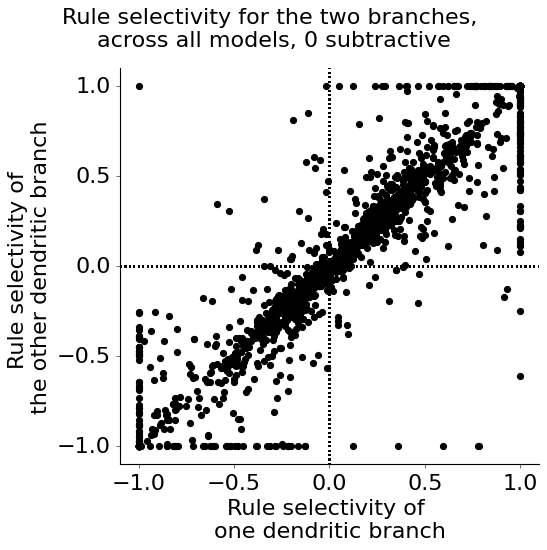

0.2
0.4
0.6
0.8


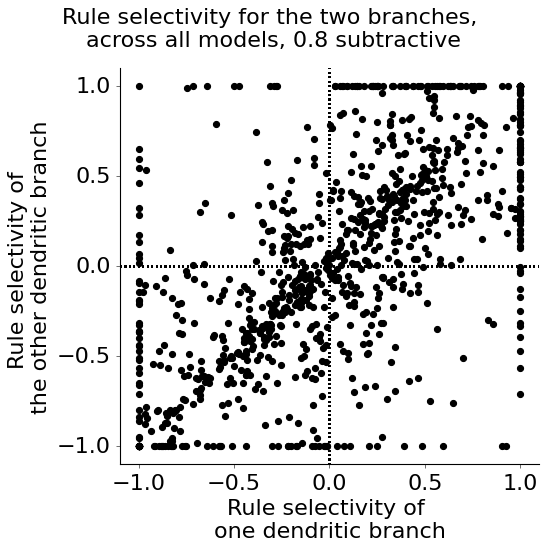

divisive_2
0
0.2
0.4
0.6
0.8


In [40]:
all_dend_nonlinears = ['subtractive', 'divisive_2']
all_sparsitys = [0, 0.2, 0.4, 0.6, 0.8]

data_fig7b = {'x': [], 'y': []}    # rule selectivity of two branches, for fully-connected SST -> exc 
data_fig7c = {'x': [], 'y': []}    # rule selectivity of two branches, for 20% connected SST -> exc 

for dend_nonlinear in all_dend_nonlinears:
    for sparsity in all_sparsitys:
        if not ((dend_nonlinear == 'subtractive' and sparsity == 0) or (dend_nonlinear == 'subtractive' and sparsity == 0.8)):
            continue
        fig, ax = plt.subplots(1, 1, figsize=[7, 7])
        fig.patch.set_facecolor('white')
        fig.suptitle('Rule selectivity for the two branches, \nacross all models, {} {}'.format(sparsity, dend_nonlinear), fontsize=20)
        ax.set_xlabel('Rule selectivity of \none dendritic branch', fontsize=20)
        ax.set_ylabel('Rule selectivity of \nthe other dendritic branch', fontsize=20)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        for x in all_data_branch_coding:
            if x['hp']['sparse_srsst_to_sredend']!=sparsity or (x['hp']['dend_nonlinearity']!=dend_nonlinear):
                continue
            
            for n in range(70):
                dend1_idx = n+70    # id of one dendritic branch
                dend2_idx = n+140    # the other branch
                ax.scatter(x=x['rule_sel_dend1_norm'][n], y=x['rule_sel_dend2_norm'][n], s=30, color='k', alpha=1)
                ax.axvline(x=0, linestyle='dotted', color='k')
                ax.axhline(y=0, linestyle='dotted', color='k')
                ax.set_xlim([-1.1, 1.1])
                ax.set_ylim([-1.1, 1.1])
            
                # source data
                if dend_nonlinear == 'subtractive' and sparsity == 0:
                    data_fig7b['x'].append(x['rule_sel_dend1_norm'][n])
                    data_fig7b['y'].append(x['rule_sel_dend2_norm'][n])
                if dend_nonlinear == 'subtractive' and sparsity == 0.8:
                    data_fig7c['x'].append(x['rule_sel_dend1_norm'][n])
                    data_fig7c['y'].append(x['rule_sel_dend2_norm'][n])

        
        make_pretty_axes(ax)
        fig.tight_layout()
        plt.show()
        fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/dend_rule_coding_sparsity{}_{}.pdf'.format(sparsity, dend_nonlinear))
# save to csv
pd.DataFrame.from_dict(data=data_fig7b, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig7b_dend_coding_dense.csv', header=False)
pd.DataFrame.from_dict(data=data_fig7c, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig7c_dend_coding_sparse.csv', header=False)

# Figure 7d: branch coding as a function of sparsity of SST->Edend

divisive_2
divisive_2, 0.8, n=350
divisive_2, 0.6000000000000001, n=280
divisive_2, 0.4, n=350
divisive_2, 0.2, n=490
divisive_2, 0.0, n=1960


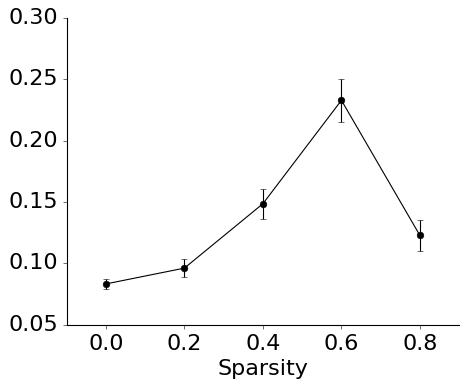

subtractive
subtractive, 0.8, n=980
subtractive, 0.6000000000000001, n=560
subtractive, 0.4, n=490
subtractive, 0.2, n=350
subtractive, 0.0, n=1890


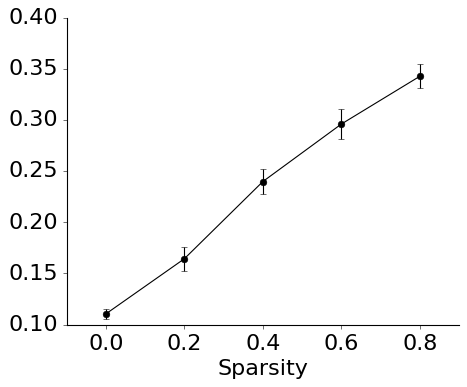

In [45]:
# branch coding as a function of sparsity of SST->Edend
import scipy.stats as stats
all_dend_nonlinears = list(set(x['hp']['dend_nonlinearity'] for x in all_data_branch_coding))


data_fig7d = {'x': [], 'y': [], 'y_err': []}
data_suppfig11a = {'x': [], 'y': [], 'y_err': []}


for dend_nonlinear in all_dend_nonlinears:
    print(dend_nonlinear)
    
#     fig, ax = plt.subplots(figsize=[6, 5])
#     fig.patch.set_facecolor('white')
# #     fig.suptitle('Difference between the rule selectivity for the two branches, \nas a function of the sparsity from SM SST to SR Edend', fontsize=20)
#     ax.set_xlabel('Sparsity', fontsize=20)
#     ax.set_ylabel('Difference in rule selectivity \nbetween branches', fontsize=20)
#     for x in all_data_branch_coding:
#         if x['hp']['dend_nonlinearity']!=dend_nonlinear:
#             continue
#         n_dends = len(x['rule_sel_dend1_norm'])
#     #     for n in range(n_dends):
#         diff_rulesel = np.abs(np.array(x['rule_sel_dend1_norm']) - np.array(x['rule_sel_dend2_norm']))
# #         print(x['rule_sel_dend1_unnorm'][0], x['rule_sel_dend1_norm'][0])
#         ax.scatter(x=x['hp']['sparse_srsst_to_sredend']*np.ones(n_dends), y=diff_rulesel, s=15, color='k', alpha=0.25)
#     ax.tick_params(axis='both', which='major', labelsize=20)
#     make_pretty_axes(ax)
#     fig.tight_layout()
#     plt.show()

    sparsities = sorted(list(set([x['hp']['sparse_srsst_to_sredend'] for x in all_data_branch_coding])), reverse=True)
    sparsity_vs_diffrulesel = dict.fromkeys(sparsities)
    for s in sparsities:
        sparsity_vs_diffrulesel[s] = {}              
        all_diff_rulesel = []
        for x in all_data_branch_coding:
#             if x['hp']['initialization_weights']!='kaiming_uniform':
#                 continue
            if x['hp']['dend_nonlinearity']!=dend_nonlinear:
                continue
            if x['hp']['sparse_srsst_to_sredend']==s:
#                 if np.isnan(x['rule_sel_dend1']).any()==True or np.isnan(x['rule_sel_dend2']).any()==True:
#                     print('nan!')
#                     print(x['rule_sel_dend1'], x['rule_sel_dend2'])
#                     continue
#                 print(np.array(x['rule_sel_dend1_norm']), np.array(x['rule_sel_dend2_norm']))
                all_diff_rulesel.extend(np.abs(np.array(x['rule_sel_dend1_norm']) - np.array(x['rule_sel_dend2_norm'])))
        mean_diff_rulesel = np.mean(all_diff_rulesel)
        print('{}, {}, n={}'.format(dend_nonlinear, s, len(all_diff_rulesel)))
        std_diff_rulesel = np.std(all_diff_rulesel)
        sem_diff_rulesel = stats.sem(all_diff_rulesel)
        sparsity_vs_diffrulesel[s]['mean_diff_rulesel'] = mean_diff_rulesel
        sparsity_vs_diffrulesel[s]['std_diff_rulesel'] = std_diff_rulesel
        sparsity_vs_diffrulesel[s]['sem_diff_rulesel'] = sem_diff_rulesel
    
#     if dend_nonlinear=='v2_std':
#         print(sparsity_vs_diffrulesel)

    #===== Plotting =====#
    fig, ax = plt.subplots(figsize=[6, 5])  
    fig.patch.set_facecolor('white')
    x = sparsities
    y = [sparsity_vs_diffrulesel[s]['mean_diff_rulesel'] for s in sparsities]
    y_err = [sparsity_vs_diffrulesel[s]['sem_diff_rulesel'] for s in sparsities]
    ax.errorbar(x=x, y=y, yerr=y_err, marker='o', color='k')
    ax.set_xlim([min(sparsities)-0.1, max(sparsities)+0.1])
    ax.set_xlabel('Sparsity', fontsize=20)
#     ax[1].set_ylabel('Mean difference in rule \nselectivity between branches', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/dend_rule_coding_{}.pdf'.format(dend_nonlinear))

    # collect source data
    if dend_nonlinear == 'subtractive':
        data_fig7d['x'] = x
        data_fig7d['y'] = y
        data_fig7d['y_err'] = y_err
    elif dend_nonlinear == 'divisive_2':
        data_suppfig11a['x'] = x
        data_suppfig11a['y'] = y
        data_suppfig11a['y_err'] = y_err

# save to csv
pd.DataFrame.from_dict(data=data_fig7d, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig7d_dend_coding_subtractive.csv', header=False)
pd.DataFrame.from_dict(data=data_suppfig11a, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig11a_dend_coding_divisive.csv', header=False)